In [0]:
!pip install -q keras

In [0]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

You have TensorFlow version 1.12.0


Using TensorFlow backend.


# Downlodaing data and pre-processing

In [0]:
!wget https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
!ls

--2018-12-03 20:05:06--  https://storage.googleapis.com/tensorflow-workshop-examples/stack-overflow-data.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.23.128, 2404:6800:4008:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.23.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44319561 (42M) [text/csv]
Saving to: ‘stack-overflow-data.csv’

stack-overflow-data 100%[===================>]  42.27M  24.0MB/s    in 1.8s    

2018-12-03 20:05:08 (24.0 MB/s) - ‘stack-overflow-data.csv’ saved [44319561/44319561]

sample_data  stack-overflow-data.csv


In [0]:
stack_df = pd.read_csv('stack-overflow-data.csv')
stack_df.head(3)

,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c


In [0]:
stack_df['tags'].value_counts()

c#               2000
c++              2000
ruby-on-rails    2000
objective-c      2000
html             2000
css              2000
jquery           2000
ios              2000
sql              2000
iphone           2000
mysql            2000
php              2000
angularjs        2000
java             2000
.net             2000
android          2000
asp.net          2000
c                2000
python           2000
javascript       2000
Name: tags, dtype: int64

In [0]:
print (len(set(stack_df['tags'])))

20


In [0]:
stack_df['post'][1]

'have dynamic html load as if it was in an iframe  i have an asp.net 4.0 site. users can save an entire html page into the backend database. what i want to do is load the dynamic content into a div on an existing page in a content area and have a couple of things to happen:    i do not want any of the css to affect anything outside the div  when first trying this out loading of some badly formed html would move images and other divs outside the content area around.    a lot of these html pages use the  base  tag for images and links  i want the base tag respected inside the div.    i have a solution that i am going to try which is just to use an iframe and set its url to another child page that loads the dynamic html into its own page entirely. i am just wondering if there is a better solution.'

In [0]:
train_val_df = stack_df[:int(len(stack_df)*0.8)]
test_df = stack_df[int(len(stack_df)*0.8):]

print ('train_val issues:', len(train_val_df))
print ('test issues:', len(test_df))

train_val issues: 32000
test issues: 8000


# Text processing

In [0]:
# removing stop words and punctuations
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import string
import re
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words = stopwords.words('english') + list(string.punctuation)
tokenizer = RegexpTokenizer(r'\w+')
sentence_cleaner_lambda = lambda s: ' '.join([w for w in tokenizer.tokenize(s.lower()) if w not in stop_words])

In [0]:
def remove_stop_words(stack_df):
    # sentence cleaner
    stack_df['post_clean'] = stack_df['post'].apply(sentence_cleaner_lambda)
    stack_df['post_clean'] = stack_df['post'].apply(sentence_cleaner_lambda)

    # replace numbers
    replace_num_lambda = lambda txt: re.sub(r'\b[0-9.]+\b', 'NUMNUMNUM', txt)
    stack_df['post_clean'] = stack_df['post_clean'].apply(replace_num_lambda)
    stack_df['post_clean'] = stack_df['post_clean'].apply(replace_num_lambda)
    
    # removing nan   
    stack_df['post_clean'] = stack_df['post_clean'].apply(lambda s: '' if str(s)=='nan' else str(s))

In [0]:
remove_stop_words(train_val_df)
remove_stop_words(test_df)

In [0]:
# train/test split on the training data
seed = 42

train_text, test_text, train_labels, test_labels = \
train_test_split(train_val_df['post_clean'], train_val_df['tags'], test_size=0.20,random_state=seed)

# Tokenize and prepare vocabulary

In [0]:
vocab_size = 15000
batch_size = 100
num_labels = 20

tokenize_train = text.Tokenizer(num_words=vocab_size, char_level=False)
tokenize_train.fit_on_texts(train_text) # only fit on train

In [0]:
x_train = tokenize_train.texts_to_matrix(train_text, mode='tfidf')
x_test = tokenize_train.texts_to_matrix(test_text, mode='tfidf')

x_fore = tokenize_train.texts_to_matrix(test_df['post'], mode='tfidf')

In [0]:
encoder = LabelBinarizer()
encoder.fit(train_labels)

y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [0]:
encoder.classes_

array(['.net', 'android', 'angularjs', 'asp.net', 'c', 'c#', 'c++', 'css',
       'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql',
       'objective-c', 'php', 'python', 'ruby-on-rails', 'sql'],
      dtype='<U13')

# First model: basic neural networks

In [0]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=3,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               7680512   
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                10260     
_________________________________________________________________
activation_2 (Activation)    (None, 20)                0         
Total params: 7,690,772
Trainable params: 7,690,772
Non-trainable params: 0
_________________________________________________________________
Train on 23040 samples, validate on 2560 samples
Epoch 1/3
23040/23040 [==============================] - 9s 391us/step - loss: 0.98

In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12635658713795235141, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11977405285857629661
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 12360400643020663244
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8904322597608381263
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [0]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

text_labels = encoder.classes_
 
for i in range(10):
    prediction = model.predict(np.array([x_test[i]]))
    predicted_label = text_labels[np.argmax(prediction[0])]
    print('Actual label:' + test_labels.iloc[i])
    print("Predicted label: " + predicted_label)

6400/6400 [==============================] - 1s 122us/step
Test score: 0.7823428539559245
Test accuracy: 0.7975000012665987
Actual label:css
Predicted label: css
Actual label:c#
Predicted label: c#
Actual label:ios
Predicted label: objective-c
Actual label:sql
Predicted label: sql
Actual label:jquery
Predicted label: jquery
Actual label:c++
Predicted label: c++
Actual label:c#
Predicted label: c#
Actual label:python
Predicted label: python
Actual label:.net
Predicted label: .net
Actual label:mysql
Predicted label: mysql


In [0]:
y_softmax = model.predict(x_test)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [0]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('int')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

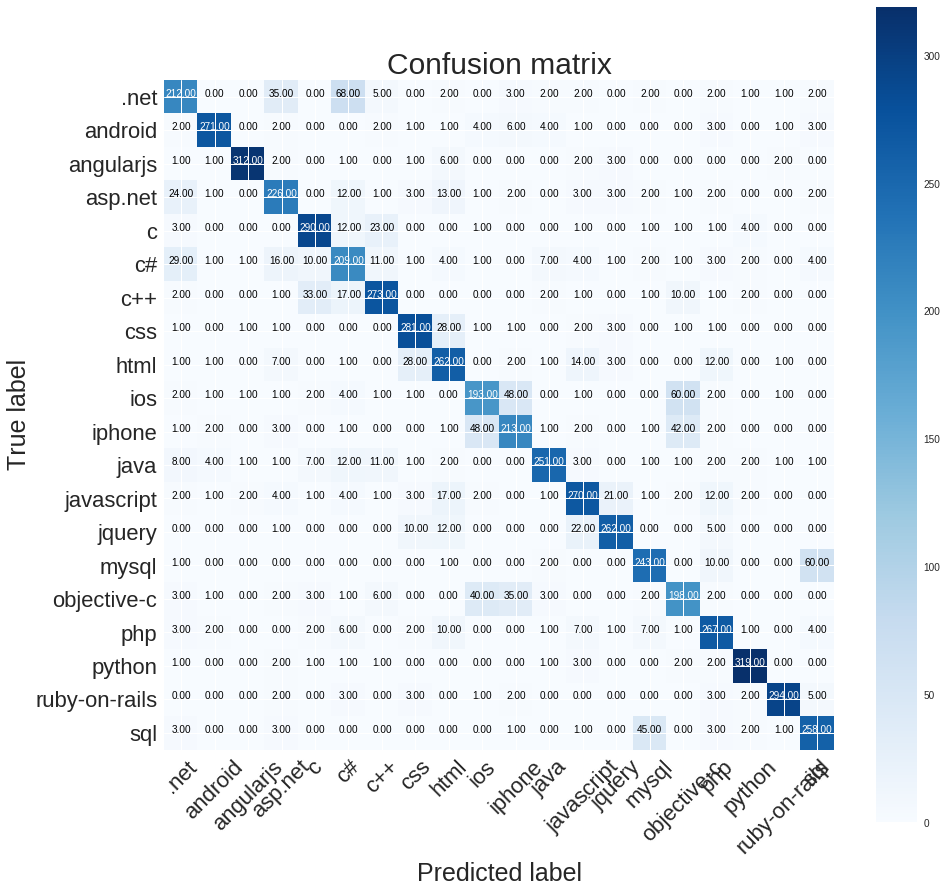

In [0]:
cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)

plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()

# model 2 adding embedding and conv and LSTM

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

In [0]:
train_sequence = tokenize_train.texts_to_sequences(train_text)
text_train_sequence = pad_sequences(train_sequence, maxlen=100)

test_sequence = tokenize_train.texts_to_sequences(test_text)
text_test_sequence = pad_sequences(test_sequence, maxlen=100)

In [0]:
model_conv = Sequential()
model_conv.add(Embedding(vocab_size, 100, input_length=100))
model_conv.add(Dropout(0.5))
model_conv.add(Conv1D(64, 5, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=4))
model_conv.add(LSTM(100))
model_conv.add(Dropout(0.5))
model_conv.add(Dense(num_labels, activation='sigmoid'))
model_conv.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_conv.summary()

model_conv.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
history = model_conv.fit(text_train_sequence, y_train,
                    batch_size=batch_size,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          1500000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 96, 64)            32064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dropout_10 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
Total para

In [0]:
score = model_conv.evaluate(text_test_sequence, y_test, batch_size=batch_size, verbose=1)

print('Test accuracy:', score[1])

6400/6400 [==============================] - 2s 304us/step
Test accuracy: 0.7329687532037497


In [0]:
y_softmax = model_conv.predict(text_test_sequence)

y_test_1d_conv = []
y_pred_1d_conv = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d_conv.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d_conv.append(predicted_index)

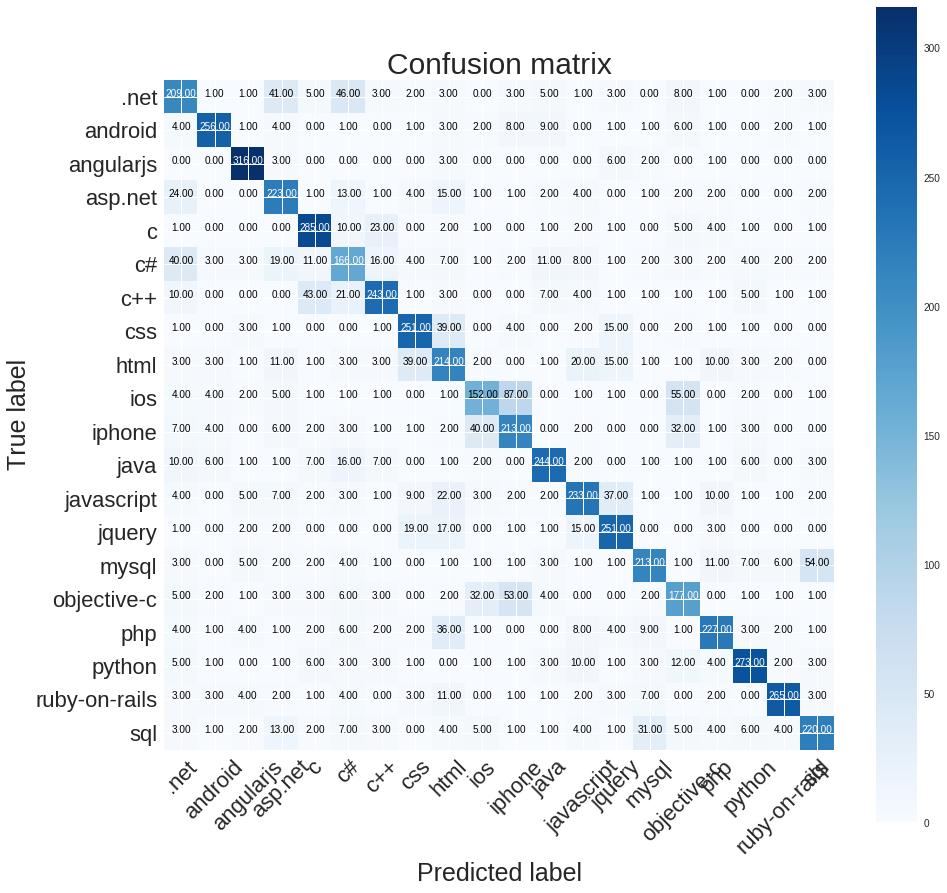

In [0]:
cnf_matrix = confusion_matrix(y_test_1d_conv, y_pred_1d_conv)

plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix, classes=text_labels, title="Confusion matrix")
plt.show()